# Multitarget training

Consider the possibility that a model trained to predict SFR, $M_\star$, and $Z$ may yield improved $Z$ estimates than a model only trained on $Z$. This might be due to fact that the learned layers may yield suitable representations for all three of these quantities, since those quantities are indeed linked. Likewise, other parameters could be relevant, such as redshift, Balmer decrement, etc...

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import sys
sys.path.append('../src')
from multiclass import *

import torch 

from IPython.display import display

In [3]:
PATH = os.path.abspath('..')

In [11]:
# train-val permutation
np.random.seed(1234)
np.random.permutation(n)

# params
sz = 128
bs = 128
arch = resnet34

# Data wrangling

In [6]:
df_full = pd.read_csv(f'{PATH}/catalogs/SDSSspecgalsDR14_boada.csv', index_col=0)
display(df_full.columns)
display(df_full.sample(5))
display(df_full.describe())

Index(['specObjID', 'ra', 'dec', 'z', 'zErr', 'velDisp', 'velDispErr',
       'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g',
       'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i',
       'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r',
       'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux',
       'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
       'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err',
       'd4000', 'd4000_err', 'bptclass', 'oh_p2p5', 'oh_p16', 'oh_p50',
       'oh_p84', 'oh_p97p5', 'lgm_tot_p50', 'sfr_tot_p50'],
      dtype='object')

,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,modelMagErr_u,modelMag_g,...,d4000,d4000_err,bptclass,oh_p2p5,oh_p16,oh_p50,oh_p84,oh_p97p5,lgm_tot_p50,sfr_tot_p50
objID,,,,,,,,,,,,,,,,,,,,,
1237662662136889578,1855555942322563072,224.913448,32.194464,0.107872,0.000009,112.55400,20.82185,20.11342,0.070109,18.64421,...,1.525160,0.026992,1,9.044375,9.082402,9.094025,9.125540,9.153540,10.327280,0.620626
1237661386543858010,1506526414633986048,246.544628,35.917125,0.032480,0.000010,68.75546,22.94688,18.85899,0.048051,17.67112,...,1.414519,0.047318,1,8.399909,8.545540,8.607080,8.688625,8.754168,9.117995,-0.693769
1237662224091644116,2087563072892856320,246.412572,21.012325,0.058008,0.000006,69.17170,27.12546,19.21305,0.082369,17.86300,...,1.388597,0.033866,1,8.669164,8.695722,8.718302,8.776249,8.812502,9.579187,-0.121077
1237666339726295173,447109836463695872,17.571397,0.403090,0.044406,0.000011,19.89343,22.47732,19.42895,0.054685,18.07506,...,1.440748,0.024921,1,8.953504,8.995851,9.015946,9.067870,9.085432,9.512147,-0.439014
1237658425160433897,1391680775610460160,150.756822,7.277533,0.062123,0.000008,75.88831,10.33038,18.56701,0.021084,17.41704,...,1.432882,0.011615,1,8.999403,9.043521,9.053862,9.108606,9.119075,10.011060,0.328800


,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,modelMagErr_u,modelMag_g,...,d4000,d4000_err,bptclass,oh_p2p5,oh_p16,oh_p50,oh_p84,oh_p97p5,lgm_tot_p50,sfr_tot_p50
count,1.421860e+05,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,...,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000,142186.000000
mean,1.670875e+18,184.374437,24.705360,0.076997,0.000009,75.457109,21.395893,18.918378,0.043612,17.671626,...,1.419777,0.022407,0.998818,8.808043,8.858256,8.906503,8.950962,8.992822,7.123441,0.156911
std,8.360386e+17,59.646105,18.799871,0.039115,0.000004,55.536267,24.567234,0.709229,0.033416,0.677756,...,0.133587,0.011272,0.048598,0.265869,0.230567,0.198560,0.178611,0.172104,169.940095,0.551883
min,2.994911e+17,0.000672,-11.216682,0.020001,0.000003,0.000000,-3.000000,12.483010,0.002975,13.351350,...,0.000000,0.000000,-1.000000,7.670827,7.771679,7.851740,7.907599,7.984161,-9999.000000,-4.296250
25%,9.391734e+17,151.289065,9.598762,0.047693,0.000007,46.811273,12.195190,18.548573,0.029515,17.339060,...,1.338242,0.014753,1.000000,8.700817,8.746164,8.808777,8.845355,8.879015,9.643470,-0.190642
50%,1.632593e+18,185.437855,23.077153,0.070907,0.000009,72.398525,16.689315,19.026515,0.039659,17.832575,...,1.407462,0.019827,1.000000,8.877043,8.925525,8.955610,8.991807,9.016777,10.055775,0.172893
75%,2.372436e+18,221.035937,38.778248,0.097837,0.000011,99.632985,24.009310,19.387577,0.052246,18.154280,...,1.491309,0.027185,1.000000,8.993226,9.014766,9.053747,9.084128,9.117110,10.416570,0.523608
max,3.348596e+18,359.994814,70.266535,0.381676,0.000130,850.000000,1600.000000,23.837450,2.829808,24.378170,...,3.873904,0.302199,1.000000,9.460500,9.463200,9.469999,9.476800,9.479500,12.492280,3.875005


In [17]:
# get SDSS IDs that correspond to training images
indices = pd.read_csv(f'{PATH}/catalogs/train-oh_p50.csv', index_col=0).index

df_train = df_full.loc[indices]

In [18]:
# columns that we want to predict 
cols = ['oh_p50', 'lgm_tot_p50', 'sfr_tot_p50', 'd4000', 'z']

df = df_train[cols].copy()
df['balmer_decrement'] = df_train.h_alpha_flux / df_train.h_beta_flux

In [19]:
# remove nans
df.dropna(inplace=True)

# remove values of -9999
df = df[df.lgm_tot_p50 != -9999]

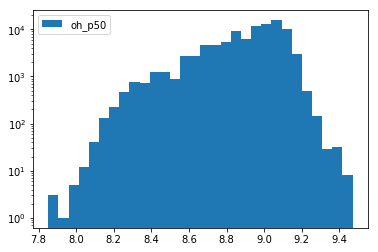

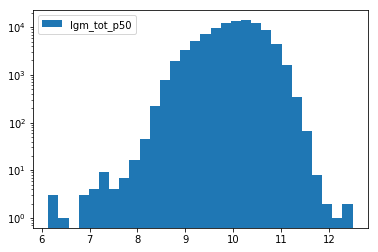

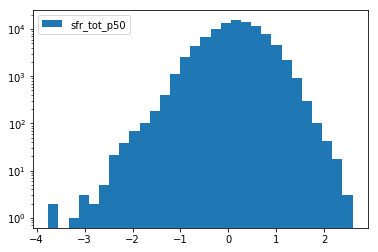

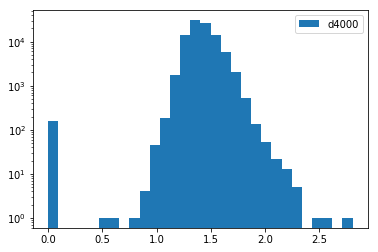

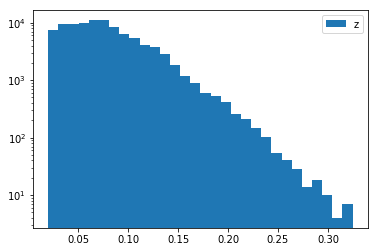

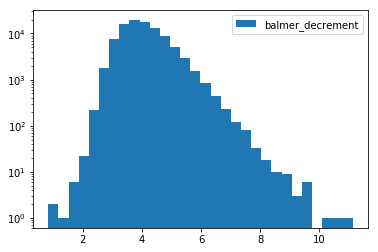

In [21]:
for col in df.columns:
    plt.hist(df[col], bins=30, log=True, label=col)
    plt.legend()
    plt.show()

In [4]:
# save out
#df.to_csv(f'{PATH}/catalogs/train-multitarget.csv')
df = pd.read_csv(f'{PATH}/catalogs/train-multitarget.csv', index_col=0)

## Repeat the same for test data

In [24]:
indices = pd.read_csv(f'{PATH}/catalogs/test-oh_p50.csv', index_col=0).index

df_test = df_full.loc[indices]

df = df_test[cols].copy()
df['balmer_decrement'] = df_test.h_alpha_flux / df_test.h_beta_flux

df.dropna(inplace=True)
df = df[df.lgm_tot_p50 != -9999]

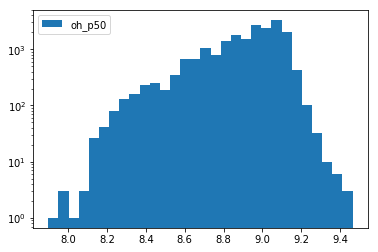

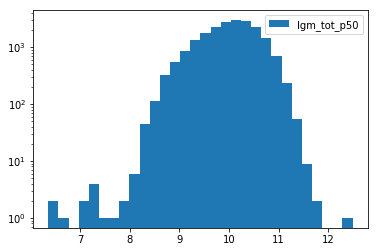

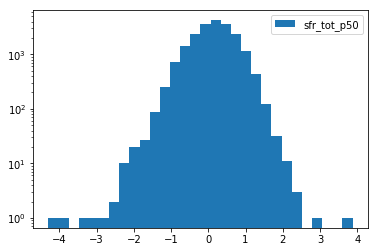

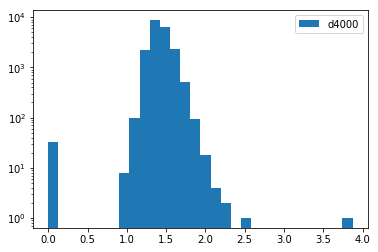

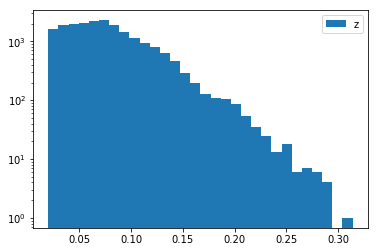

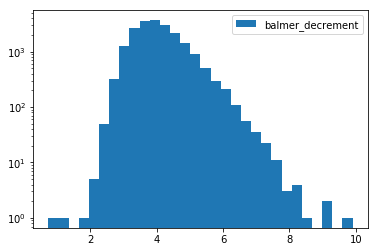

In [25]:
for col in df.columns:
    plt.hist(df[col], bins=30, log=True, label=col)
    plt.legend()
    plt.show()

In [26]:
df.to_csv(f'{PATH}/catalogs/test-multitarget.csv')

# Training

## Setting up

In [5]:
train_label_csv = f'{PATH}/catalogs/train-multitarget.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n)

In [37]:
def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)


In [39]:
# params
sz = 128
bs = 128
arch = resnet34

In [40]:
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data, pretrained=False)
metrics = [rmse]
learn.crit = rmse

## Finding learning rate

 89%|████████▉ | 1065/1199 [01:33<00:11, 11.35it/s, loss=2.32] 

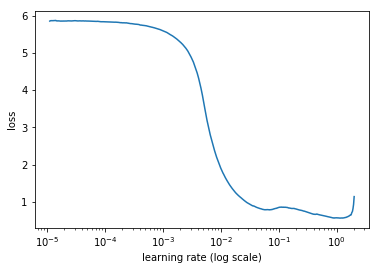

 89%|████████▉ | 1065/1199 [01:50<00:13,  9.68it/s, loss=2.32]

In [41]:
learn.lr_find()
learn.sched.plot()

## Standard training regiment

epoch      trn_loss   val_loss                                 
    0      0.368578   0.355979  
    1      0.361853   0.33272                                  


epoch      trn_loss   val_loss                                 
    0      0.293408   0.297489  


epoch      trn_loss   val_loss                                 
    0      0.287387   0.26819   
    1      0.279438   0.268853                                 
    2      0.275396   0.264289                                 
    3      0.284936   0.280146                                 
    4      0.273638   0.276206                                 
    5      0.274002   0.261008                                 
    6      0.268651   0.259562                                 


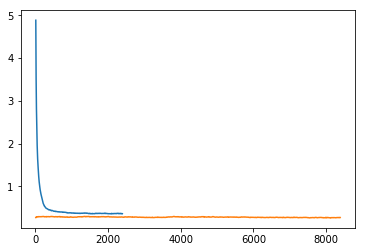

In [42]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-2, 3e-2, 1e-1]
learn.unfreeze()

learn.fit(lrs, 1)
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [43]:
#learn.save('resnet34_multitarget-regular')
learn.load('resnet34_multitarget-regular')

# Examine predictions

In [45]:
preds = learn.TTA(is_test=True)[0].mean(axis=0)


In [62]:
df_pred = pd.DataFrame(data=preds, index=indices, columns=df.columns)

## Answer key

In [56]:
df_true = pd.read_csv(f'{PATH}/catalogs/test-multitarget.csv', index_col=0)
df_true.head(5)

,oh_p50,lgm_tot_p50,sfr_tot_p50,d4000,z,balmer_decrement
objID,,,,,,
1237648672922206684,8.676655,9.433080,0.045122,1.337505,0.065651,3.752570
1237648673431879906,8.915661,10.499040,0.293388,1.647457,0.077888,5.450780
1237648673458028997,8.824834,9.694625,0.140291,1.420438,0.066615,3.693142
1237648673459470810,8.598277,9.311505,-0.456691,1.317906,0.046537,3.117777
1237648673994768731,8.486758,9.260650,-0.952921,1.489409,0.028943,3.776626


Make indices match (e.g., remove some that have nans or -9999 in the "truths").

In [63]:
df_pred = df_pred.loc[df_true.index]

In [64]:
df_pred.head(5)

,oh_p50,lgm_tot_p50,sfr_tot_p50,d4000,z,balmer_decrement
objID,,,,,,
1237648672922206684,8.708987,9.382991,-0.384358,1.350354,0.046819,3.564259
1237648673431879906,8.719133,9.514215,-0.022682,1.321251,0.060300,3.411083
1237648673458028997,9.021193,10.392543,0.909887,1.293198,0.124818,4.279572
1237648673459470810,9.020337,10.595610,0.364855,1.597625,0.089674,4.756908
1237648673994768731,8.582023,9.150290,-0.534865,1.320011,0.042663,3.402697


## Examine predictions

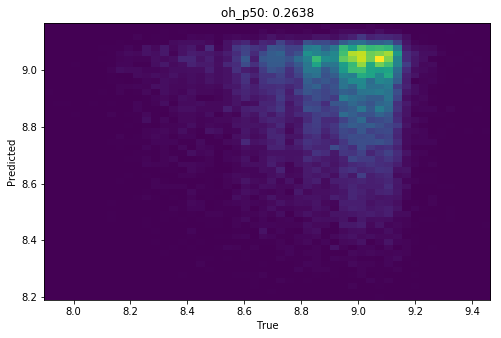

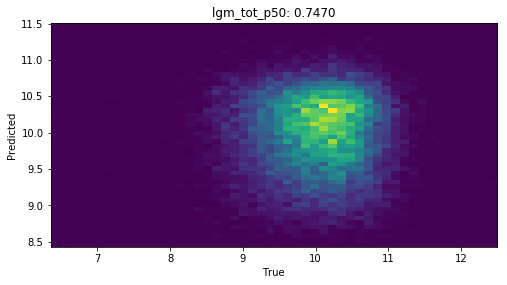

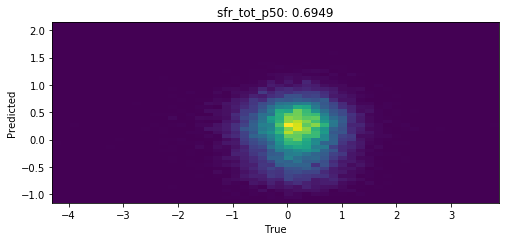

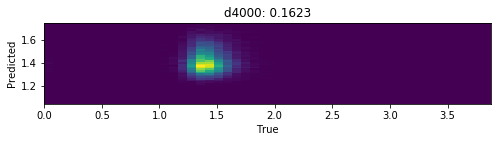

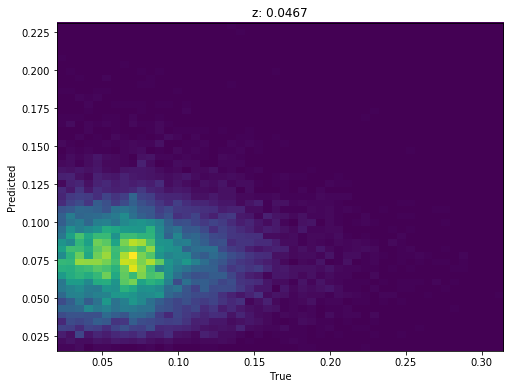

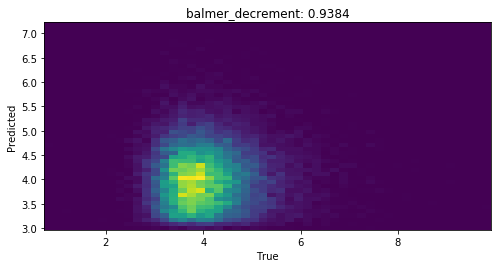

In [66]:
for col in df_true.columns:
    # "y" is just a general galaxy property
    y_pred = df_pred[col].values
    y_true = df_true[col].values
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
    ax.hist2d(x=y_true, y=y_pred, bins=50)
    ax.set_aspect('equal')
    
    loss = rmse_np(y_pred, y_true)
    
    ax.set_title(f'{col}: {loss:.4f}')
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')

Hmm... could it be that we're using the wrong training metric?

# Try random initialized, superconvergent training

In [9]:
train_label_csv = f'{PATH}/catalogs/train-multitarget.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n)

def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)


In [12]:
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data, pretrained=False)
metrics = [rmse]
learn.crit = rmse

In [ ]:
learn.unfreeze()

lr = 0.1            # maximum lr
lr_factor = 10      # minimum lr = lr/lr_factor
lr_anneal_pct = 15. # percentage of cycle to cosine anneal

cycle_len = 70

momentum_max = 0.95 # maximum of momentum (when at min lr)
momentum_min = 0.85 # minimum of momentum (when at max lr)
weight_decay = 1e-4 # weight decay (constant)

learn.fit(lr, 1, 
          cycle_len=cycle_len, 
          use_clr_beta=(lr_factor, lr_anneal_pct, momentum_max, momentum_min), 
          wds=weight_decay)

 87%|████████▋ | 1042/1199 [02:35<00:23,  6.68it/s, loss=0.455]

In [ ]:
learn.save('resnet34_multitarget-ri_sc')
learn.load('resnet34_multitarget-ri_sc')

In [ ]:
learn.sched.plot_loss(n_skip=1200)
plt.plot(np.arange(1, cycle_len+1)*1200, learn.sched.val_losses)

In [ ]:
# get TTA predictions
preds = learn.TTA(is_test=True)[0].mean(axis=0)
df_pred = pd.DataFrame(data=preds, index=indices, columns=df.columns)

# answers
df_true = pd.read_csv(f'{PATH}/catalogs/test-multitarget.csv', index_col=0)

# align
df_pred = df_pred.loc[df_true.index]

In [ ]:
for col in df_true.columns:
    # "y" is just a general galaxy property
    y_pred = df_pred[col].values
    y_true = df_true[col].values
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
    ax.hist2d(x=y_true, y=y_pred, bins=50)
    ax.set_aspect('equal')
    
    loss = rmse_np(y_pred, y_true)
    
    ax.set_title(f'{col}: {loss:.4f}')
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')